In [3]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
df_test = pd.read_csv("./training_data/merged_train_i1.csv", sep=';')

not_chosen_columns = ['ID', 'Tweet']
label_columns = [col for col in df_test.columns if col not in not_chosen_columns]

df_labels_test = df_test[label_columns]

list_labels_test = df_labels_test.values.tolist()

test_texts = df_test['Tweet'].tolist()
test_labels = list_labels_test

tokenizer = BertTokenizer.from_pretrained("saved_model")
model = BertForSequenceClassification.from_pretrained("saved_model")

In [5]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_probabilities = []

# Process each text
for text in test_texts:
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.sigmoid(logits)  # Apply sigmoid to convert logits to probabilities
    probabilities = probabilities.squeeze(0)
    probabilities = probabilities.cpu()

    all_probabilities.append(probabilities) #Değiştir

In [6]:
all_probabilities_l = []

for item in all_probabilities:
    all_probabilities_l.append(item.tolist())

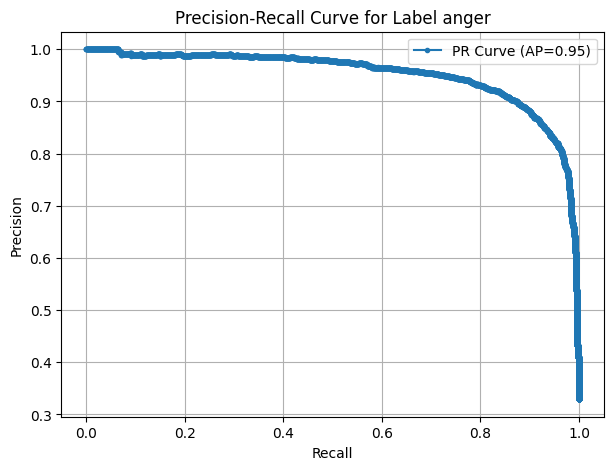

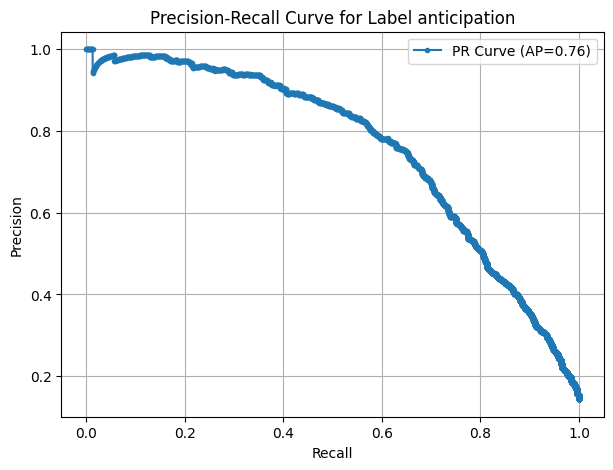

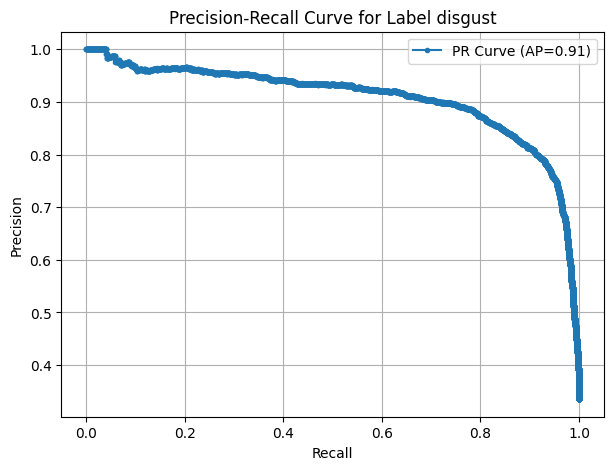

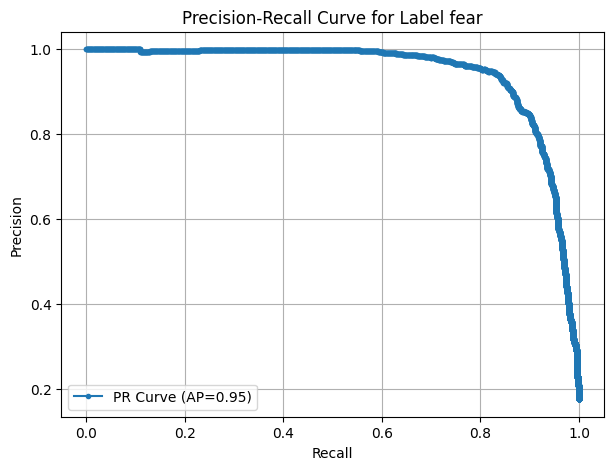

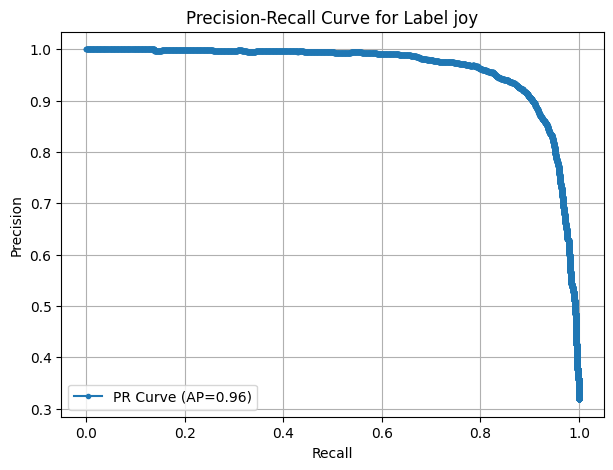

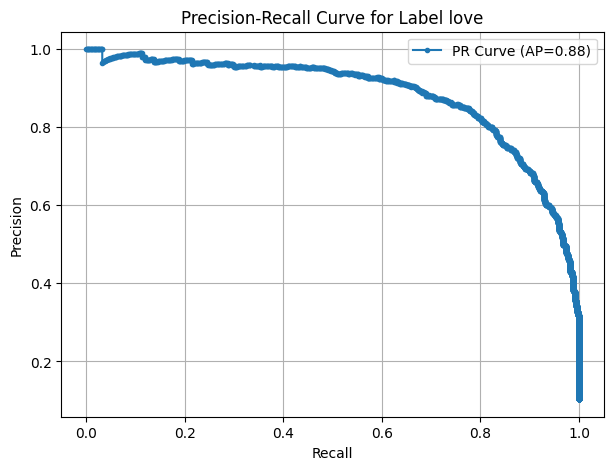

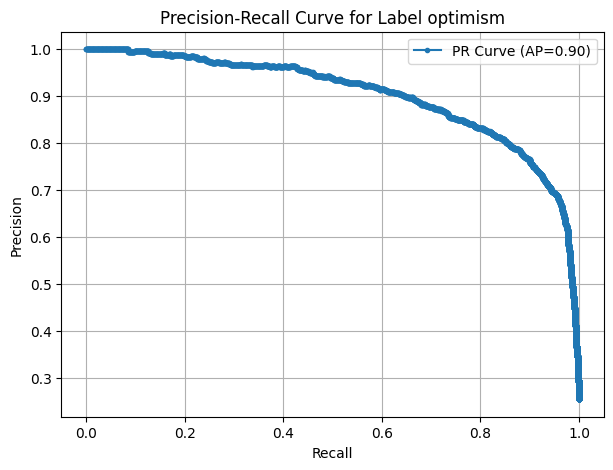

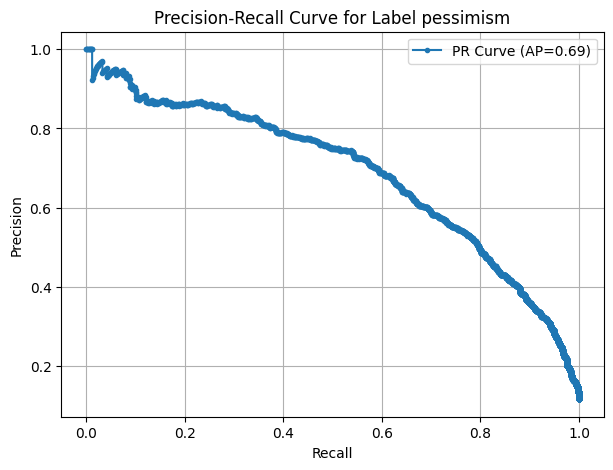

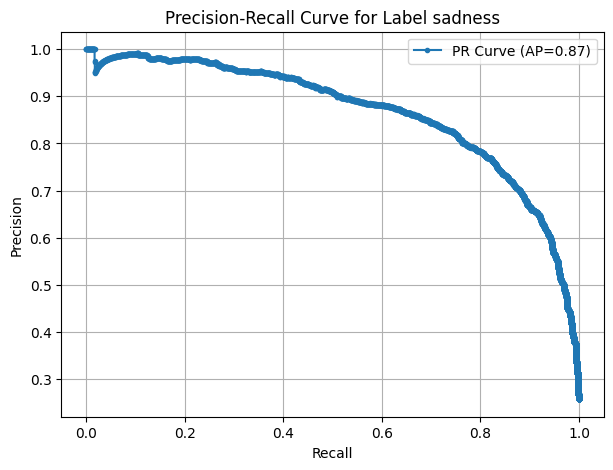

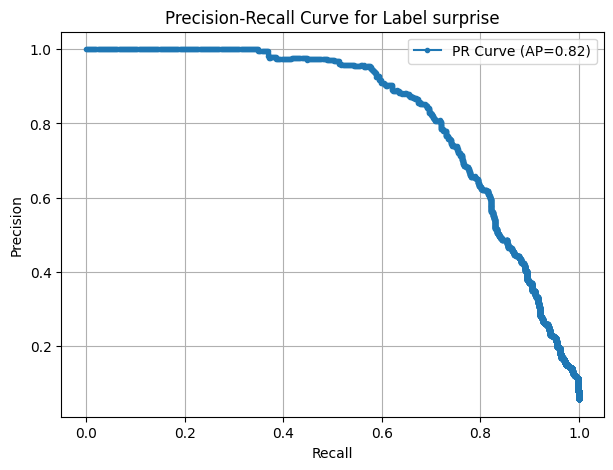

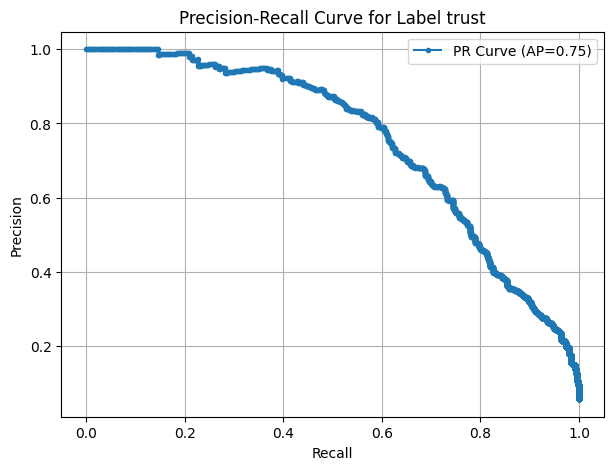

[0.38, 0.4, 0.34, 0.54, 0.46, 0.56, 0.47, 0.55, 0.36, 0.5, 0.65]


,0,1,2,3,4,5,6,7,8,9,10
0,0.050620,0.327477,0.034989,0.312191,0.555620,0.112352,0.975886,0.071582,0.038410,0.030727,0.814145
1,0.039139,0.092431,0.021327,0.016597,0.956853,0.542009,0.920744,0.017872,0.025991,0.030859,0.263537
2,0.245433,0.194477,0.212806,0.026030,0.915777,0.117464,0.448060,0.039221,0.044006,0.423578,0.242855
3,0.031131,0.270042,0.017604,0.050474,0.945663,0.304332,0.976350,0.033308,0.021463,0.057527,0.621792
4,0.939601,0.037805,0.937093,0.163904,0.025259,0.013997,0.016078,0.084415,0.372882,0.030220,0.013539
...,...,...,...,...,...,...,...,...,...,...,...
8195,0.062661,0.078468,0.117874,0.966491,0.032649,0.028750,0.022761,0.182583,0.160731,0.144877,0.028880
8196,0.037209,0.037308,0.036273,0.046802,0.513221,0.895578,0.162758,0.059954,0.080148,0.038489,0.059527
8197,0.029149,0.105907,0.031813,0.018951,0.820356,0.118358,0.146385,0.019634,0.020163,0.155012,0.043080
8198,0.051754,0.062696,0.110710,0.064242,0.084254,0.050904,0.072648,0.832688,0.936211,0.032082,0.031275


In [7]:
#Precision-Recall curve 

from sklearn.metrics import precision_recall_curve, average_precision_score

def optimize_threshold_pr(y_true, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # Avoid division by zero
    best_threshold = thresholds[np.argmax(f1_scores)]

    return best_threshold

all_probabilities_pd = pd.DataFrame(all_probabilities_l)
test_labels_pd = pd.DataFrame(test_labels)

found_thres = []

for i in range( all_probabilities_pd.shape[1] ):

    col_prob = all_probabilities_pd.iloc[:,i]
    col_prob= torch.tensor(col_prob)

    col_true = test_labels_pd.iloc[:,i]
    col_true= torch.tensor(col_true)

    best_thresh = optimize_threshold_pr(col_true, col_prob)

    precisions, recalls, thresholds = precision_recall_curve(col_true, col_prob)
    ap_score = average_precision_score(col_true, col_prob)

    emotions = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]

    plt.figure(figsize=(7, 5))
    plt.plot(recalls, precisions, marker=".", label=f"PR Curve (AP={ap_score:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for Label {emotions[i]}")
    plt.legend()
    plt.grid()
    plt.show()
    
    found_thres.append(round(best_thresh, 2))

print(found_thres)

all_probabilities_pd